In [21]:
from netCDF4 import Dataset
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
from wrf import get_cartopy, getvar, latlon_coords, to_np, extract_times, ALL_TIMES
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'cloudfrac-rain-multi-vid.ju.py'
RUN_IDS = [45, 63, 46]

root_dir = '/home/guc/'
data_dir = 'tmp/'
image_dir = glob(root_dir + data_dir)[0]

template_dataset = Dataset(glob(f'/home/guc/runs/045-*/wrfout*')[0])
template_var = getvar(template_dataset, "PBLH", timeidx=0)
column_size = len(RUN_IDS)

In [47]:
def plot_image(debug: bool = False) -> None:
    times = extract_times(template_dataset, timeidx=ALL_TIMES)

    z_data = getvar(template_dataset, "z", timeidx=0)
    lats, lons = latlon_coords(z_data)
    cart_proj = get_cartopy(z_data)
    plot_lim = np.linspace(0, 0.5, 21)
    plot_lim_rain = np.linspace(0, 0.5, 21)
    
    if debug: times = times[120:121]

    for time_idx, datetime in enumerate(times):
        fig, axes = plt.subplots(2, column_size, figsize=(8, 3), subplot_kw={'projection': cart_proj}, sharex=True)
        datetime_string = np.datetime_as_string(datetime, unit='m').replace('T', ' ')
        fig.suptitle(f"Cloud Fraction (Top) and QRAIN (Bottom), Ideal Condition at {datetime_string}")
        for i, run_id in enumerate(RUN_IDS):
            print(f'Processing RUN_ID={run_id}, {datetime}', end='\r')

            file_name = glob(f'/home/guc/runs/0{run_id}*/wrfout*')[0]

            dataset = Dataset(file_name)

            cloudfrac_data = getvar(dataset, "CLDFRA", timeidx=time_idx)
            mean_cloudfrac = np.mean(to_np(cloudfrac_data), axis=0)

            rain_data = getvar(dataset, "QRAIN", timeidx=time_idx)
            mean_rain = np.mean(to_np(rain_data), axis=0)

            gridlines = axes[0][i].gridlines(
                crs=crs.PlateCarree(),
                draw_labels=True,
                x_inline=False,
                y_inline=False,
                linewidth=0.1,
                color="black",
                linestyle="dotted",
            )
            gridlines.top_labels = None
            gridlines.bottom_labels = None
            gridlines.right_labels = None

            gridlines = axes[1][i].gridlines(
                crs=crs.PlateCarree(),
                draw_labels=True,
                x_inline=False,
                y_inline=False,
                linewidth=0.1,
                color="black",
                linestyle="dotted",
            )
            gridlines.top_labels = None
            gridlines.right_labels = None

            contour = axes[0][i].contourf(
                to_np(lons),
                to_np(lats),
                mean_cloudfrac,
                plot_lim,
                cmap="Spectral_r",
                extend='max',
                transform=crs.PlateCarree()
            )

            contour_rain = axes[1][i].contourf(
                to_np(lons),
                to_np(lats),
                mean_rain,
                plot_lim_rain,
                cmap="Spectral_r",
                extend='max',
                transform=crs.PlateCarree()
            )

            axes[0][i].set_title(f'ID = {run_id}')

            axes[0][i].grid(linewidth=0.1)
            axes[1][i].grid(linewidth=0.1)

            if i == column_size - 1:
                fig.subplots_adjust(right=0.8)
                cbar_ax = fig.add_axes((0.825, 0.125, 0.01, 0.75))
                cbar = fig.colorbar(contour, cax=cbar_ax, ticks=plot_lim[::5])
                cbar.ax.set_ylabel('Cloud Fraction')

                cbar_ax = fig.add_axes((0.925, 0.125, 0.01, 0.75))
                cbar = fig.colorbar(contour_rain, cax=cbar_ax, ticks=plot_lim_rain[::5])
                cbar.ax.set_ylabel('QRAIN')

        if not debug:
            output_name = image_dir + np.datetime_as_string(datetime, unit='s') + '.png'
            plt.savefig(output_name)
            plt.clf()
            plt.close()

Starting visualization for cloudfrac-rain-multi


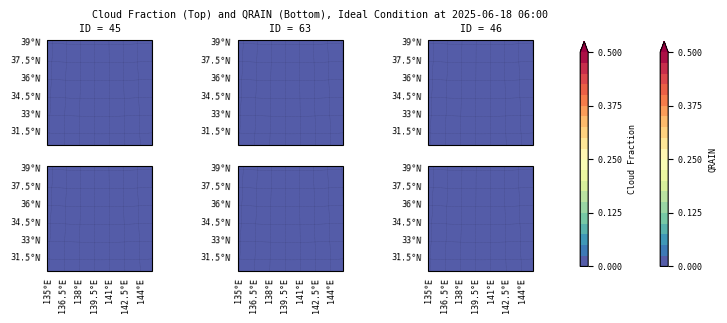

In [48]:
plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 6

import subprocess
print(f'Starting visualization for cloudfrac-rain-multi')
plot_image(not is_py)

# Call ffmpeg to create video
if is_py:
    subprocess.call(['/home/guc/scripts/visualize/tmp-generate-video.sh'])
    subprocess.call(['mv', 'out.mp4', root_dir + f'results/bdy-height-multi-{len(glob(root_dir + f'results/bdy-height-multi*.mp4')) + 1}.mp4'])
    for image_name in glob(image_dir + '*.png'):
        os.remove(image_name)
    print('Done!!')